# Starbucks Capstone Challenge

# Project Definition
### Project Overview
Stabucks provided simulated data that minics customer behavior on the Starbucks rewards mobile app. Starbucks sends out offers to their customer through multiple channel likes mobile app, web, email, or social media. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

This blog is a part of the Capstone Project in Udacity
### Problem Statement
This project will try to build a model that predict whether a user will complete the offer or not. In order to do that we will go through the process
1. Exploring the data
2. Cleaning the data
3. Combining 3 dataset for modeling
4. Splitting data into training test dataset
5. Training 3 classifier as a base model and choose the best of them
6. Improve the model by using different parameters and GridSearchCV
7. Evalution the model result

### Metrics
In this project, we will use accuracy_score and f1_score. As 1st we use accuracy for simply and quick but because we got imbalanced dataset so we need to use f1 and then we will use confusion matrix to summary the result.

# Analysis

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration & Data Visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

#### Portfolio Dataset

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.sort_values(by=['reward'])

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


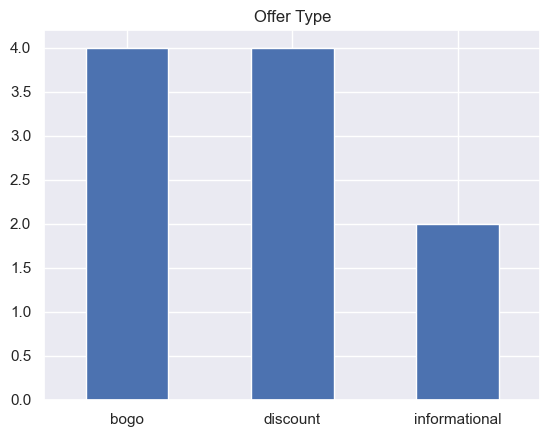

In [5]:
plt.subplot(111)
portfolio.offer_type.value_counts().plot.bar(rot=0)
plt.title('Offer Type');


Profolio dataset contains 10 records for 10 different offers from Starbucks and distribute into 3 type BOGO, Discount and Information.

The reward after completed the offer runs from 0 to 10 and also coresponse with the difficulty level.

#### Profile Dataset

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


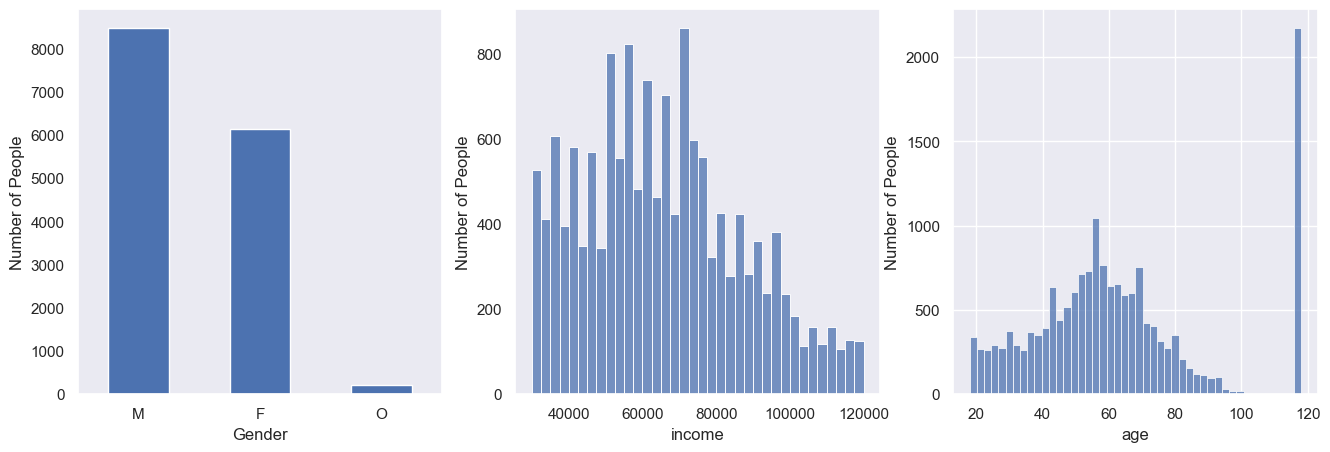

In [9]:
plt.figure(figsize=(16,5))

plt.subplot(131)
profile.gender.value_counts().plot(kind='bar', rot=0);
plt.ylabel('Number of People');
plt.xlabel('Gender');
plt.grid();

plt.subplot(132)
sns.histplot(data=profile, x="income")
plt.ylabel('Number of People');
plt.grid();

plt.subplot(133)
sns.histplot(data=profile, x="age")
plt.ylabel('Number of People');
plt.grid(True);


The profile dataset contains 17,000 entries, some of which have null values in the gender and income columns. 

The dashboard provides a visual representation of the distribution of members by gender, age, and income. The data shows that there are more male members than female, with a smaller population in the "other" category. 

The age group with the highest representation is between 50 and 70 years old. In terms of income, members with incomes ranging from 40k to 80k are the most common. 

In [10]:
len(profile[profile['age'] == 118])

2175

In [11]:
len(profile[profile['income'].isna()])

2175

Profile dataset needs to be cleaned as it contains null values and an age value of 118 that appears frequently due to a data entry error.

#### Transcript Dataset

In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
transcript.isnull().any()

person    False
event     False
value     False
time      False
dtype: bool

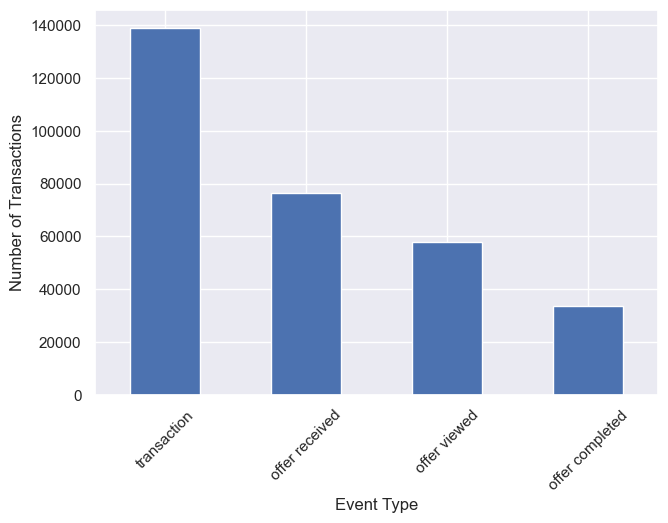

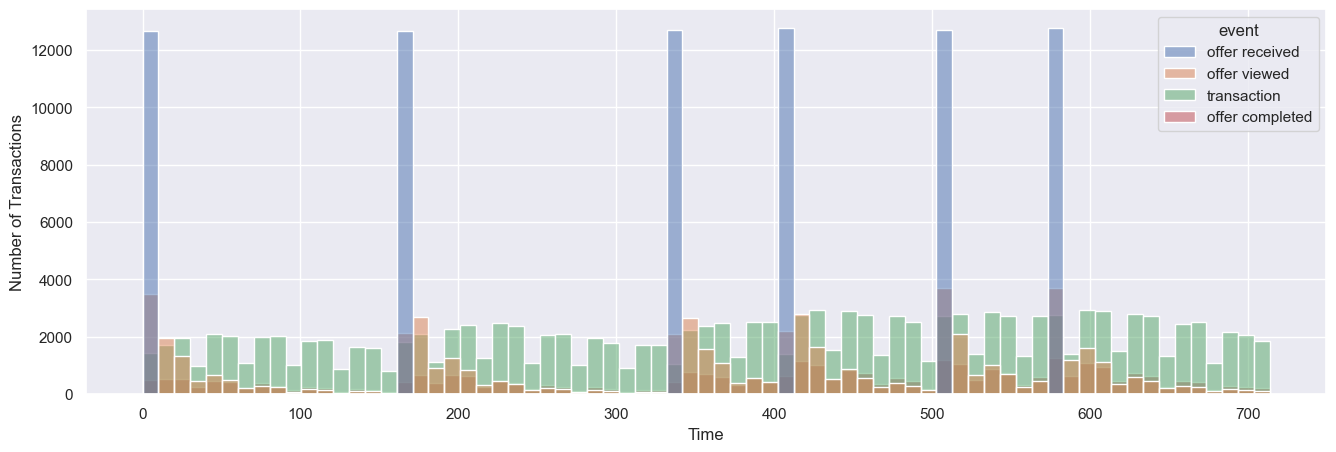

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(121)
transcript.event.value_counts().plot.bar(rot=45);
plt.ylabel('Number of Transactions');
plt.xlabel('Event Type');
plt.grid(True);

plt.figure(figsize=(16,5))
sns.histplot(data=transcript, x="time", hue="event")
plt.ylabel('Number of Transactions');
plt.xlabel('Time');
plt.grid(True);

Transcript table consists 306534 records and does not contain null values but this table store "value" column in json format and we need to extract all the information for each type of event.

# Methodology

### Data Preprocessing

#### Porfolio Prepocessing

In [16]:
prepocessed_porfolio = portfolio.rename(columns={'id': 'offer_id'})

In [17]:
channels = prepocessed_porfolio['channels'].map(lambda x: ','.join(x)).str.get_dummies(',')
channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [18]:
offer_type = pd.get_dummies(prepocessed_porfolio['offer_type'])
offer_type

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [19]:
prepocessed_porfolio.drop(columns=['channels', 'offer_type'], inplace=True)
prepocessed_porfolio

,reward,difficulty,duration,offer_id
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,4,3f207df678b143eea3cee63160fa8bed
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d
9,2,10,7,2906b810c7d4411798c6938adc9daaa5


In [20]:
prepocessed_porfolio = pd.concat([prepocessed_porfolio, channels, offer_type], axis=1)
prepocessed_porfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


#### Profile Prepocessing

As what I realized in the previous step, profile dataset contains 2175 records with age is 118 and income is null. Firstly, we will drop these records because they do not provide much information for our process.

In [21]:
invalid_profile_id = profile[profile.age == 118]['id']
invalid_profile_id

0        68be06ca386d4c31939f3a4f0e3dd783
2        38fe809add3b4fcf9315a9694bb96ff5
4        a03223e636434f42ac4c3df47e8bac43
6        8ec6ce2a7e7949b1bf142def7d0e0586
7        68617ca6246f4fbc85e91a2a49552598
                       ...               
16980    5c686d09ca4d475a8f750f2ba07e0440
16982    d9ca82f550ac4ee58b6299cf1e5c824a
16989    ca45ee1883624304bac1e4c8a114f045
16991    a9a20fa8b5504360beb4e7c8712f8306
16994    c02b10e8752c4d8e9b73f918558531f7
Name: id, Length: 2175, dtype: object

In [22]:
prepocessed_profile = profile[profile.age != 118]
prepocessed_profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [23]:
prepocessed_profile.isnull().any()

gender              False
age                 False
id                  False
became_member_on    False
income              False
dtype: bool

After dropping, 118 years old profiles we also get rid of null values in profile dataset.

In [24]:
prepocessed_profile = prepocessed_profile.rename(columns={'id': 'person_id'})

In [25]:
gender = pd.get_dummies(prepocessed_profile['gender'])
gender.rename(columns={'F': 'Female', 'M': 'Male', 'O': 'Other'}, inplace=True)
gender

,Female,Male,Other
1,1,0,0
3,1,0,0
5,0,1,0
8,0,1,0
12,0,1,0
...,...,...,...
16995,1,0,0
16996,0,1,0
16997,0,1,0
16998,1,0,0


In [26]:
prepocessed_profile['became_member_on'] = pd.to_datetime(prepocessed_profile['became_member_on'],format='%Y%m%d')
prepocessed_profile

,gender,age,person_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [27]:
from datetime import datetime

now = datetime.now()
prepocessed_profile['membership_days'] = (now - prepocessed_profile['became_member_on']).dt.days
prepocessed_profile

,gender,age,person_id,became_member_on,income,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2156
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2223
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1871
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1947
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2037
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1832
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1793
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2326
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2651


In [28]:
prepocessed_profile.drop(columns=['became_member_on', 'gender'], axis=1, inplace=True)


In [29]:
prepocessed_profile = pd.concat([prepocessed_profile, gender], axis=1)
prepocessed_profile

,age,person_id,income,membership_days,Female,Male,Other
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2156,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2223,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,1871,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,1947,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2037,0,1,0
...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1832,1,0,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1793,0,1,0
16997,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2326,0,1,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2651,1,0,0


#### Transcript Preprocessing

In [30]:
prepocessed_transcript = transcript[~transcript.person.isin(invalid_profile_id)]
prepocessed_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714


In [31]:
prepocessed_transcript = prepocessed_transcript.rename(columns={'person': 'person_id'})

In [32]:
event_type = pd.get_dummies(prepocessed_transcript['event']);
event_type.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)
event_type

,offer_completed,offer_received,offer_viewed,transaction
0,0,1,0,0
2,0,1,0,0
5,0,1,0,0
7,0,1,0,0
8,0,1,0,0
...,...,...,...,...
306527,1,0,0,0
306529,0,0,0,1
306530,0,0,0,1
306531,0,0,0,1


In [33]:
prepocessed_transcript.drop(columns=["event"], inplace=True)
prepocessed_transcript = pd.concat([prepocessed_transcript, event_type], axis=1)
prepocessed_transcript

,person_id,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
...,...,...,...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1,0,0,0
306529,b3a1272bc9904337b331bf348c3e8c17,{'amount': 1.5899999999999999},714,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,{'amount': 9.53},714,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,{'amount': 3.61},714,0,0,0,1


For investigating more about offer interaction, we take only event offer_completed, offer_received, offer_viewed for analytic and then parse value column to get offer_id

In [34]:
prepocessed_transcript_offer_received = prepocessed_transcript[prepocessed_transcript['offer_received'] == 1].drop(columns=["offer_completed", "offer_viewed", "transaction"])
prepocessed_transcript_offer_received['offer_id'] = prepocessed_transcript_offer_received['value'].apply(lambda x: x['offer id'])
prepocessed_transcript_offer_received.drop(columns=["value"], inplace=True)
prepocessed_transcript_offer_received.rename(columns={'time': 'offer_received_time'}, inplace=True)
prepocessed_transcript_offer_received

,person_id,offer_received_time,offer_received,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,0,1,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,0,1,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,576,1,ae264e3637204a6fb9bb56bc8210ddfd
257883,cb23b66c56f64b109d673d5e56574529,576,1,2906b810c7d4411798c6938adc9daaa5
257884,6d5f3a774f3d4714ab0c092238f3a1d7,576,1,2298d6c36e964ae4a3e7e9706d1fb8c2
257885,9dc1421481194dcd9400aec7c9ae6366,576,1,ae264e3637204a6fb9bb56bc8210ddfd


In [35]:
prepocessed_transcript_offer_viewed = prepocessed_transcript[prepocessed_transcript['offer_viewed'] == 1].drop(columns=["offer_completed", "offer_received", "transaction"])
prepocessed_transcript_offer_viewed['offer_id'] = prepocessed_transcript_offer_viewed['value'].apply(lambda x: x['offer id'])
prepocessed_transcript_offer_viewed.drop(columns=["value"], inplace=True)
prepocessed_transcript_offer_viewed.rename(columns={'time': 'offer_viewed_time'}, inplace=True)
prepocessed_transcript_offer_viewed

,person_id,offer_viewed_time,offer_viewed,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,1,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,1,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,1,5a8bc65990b245e5a138643cd4eb9837
...,...,...,...,...
306433,ec1761735b034ae8874bc979f0cd5862,714,1,5a8bc65990b245e5a138643cd4eb9837
306450,9b51e8797290403b90d09d864dec4b94,714,1,3f207df678b143eea3cee63160fa8bed
306483,84fb57a7fe8045a8bf6236738ee73a0f,714,1,5a8bc65990b245e5a138643cd4eb9837
306490,abc4359eb34e4e2ca2349da2ddf771b6,714,1,3f207df678b143eea3cee63160fa8bed


In [36]:
prepocessed_transcript_offer_completed = prepocessed_transcript[prepocessed_transcript['offer_completed'] == 1]\
                                            .drop(columns=["offer_viewed", "offer_received", "transaction"])
prepocessed_transcript_offer_completed['offer_id'] = prepocessed_transcript_offer_completed['value'].apply(lambda x: x['offer_id'])
prepocessed_transcript_offer_completed['transcript_reward'] = prepocessed_transcript_offer_completed['value'].apply(lambda x: x['reward'])
prepocessed_transcript_offer_completed.drop(columns=["value"], inplace=True)
prepocessed_transcript_offer_completed.rename(columns={'time': 'offer_completed_time'}, inplace=True)
prepocessed_transcript_offer_completed

,person_id,offer_completed_time,offer_completed,offer_id,transcript_reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,0,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10
...,...,...,...,...,...
306456,f3e801caeafe4899b3b989b586e74ac7,714,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
306470,452cdae2c68e4732a4177d3929562690,714,1,fafdcd668e3743c1bb461111dcafc2a4,2
306475,0c027f5f34dd4b9eba0a25785c611273,714,1,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306509,8431c16f8e1d440880db371a68f82dd0,714,1,fafdcd668e3743c1bb461111dcafc2a4,2


In [37]:
tmp_df = pd.merge(prepocessed_transcript_offer_received, prepocessed_transcript_offer_viewed, on=['person_id', 'offer_id'], how='outer')
prepocessed_transcript_offer = pd.merge(tmp_df, prepocessed_transcript_offer_completed, on=['person_id', 'offer_id'], how='outer')
prepocessed_transcript_offer

,person_id,offer_received_time,offer_received,offer_id,offer_viewed_time,offer_viewed,offer_completed_time,offer_completed,transcript_reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1.0,132.0,1.0,5.0
1,e2127556f4f64592b11af22de27a7932,0,1,2906b810c7d4411798c6938adc9daaa5,18.0,1.0,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1.0,60.0,1.0,5.0
3,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1.0,600.0,1.0,5.0
4,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,504.0,1.0,60.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...
102688,670626b55bfb4ba39c85b27cc7cca527,576,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,624.0,1.0,666.0,1.0,5.0
102689,a57890c3bbb7463e9018abb7fecadb15,576,1,5a8bc65990b245e5a138643cd4eb9837,576.0,1.0,NaN,NaN,NaN
102690,d087c473b4d247ccb0abfef59ba12b0e,576,1,ae264e3637204a6fb9bb56bc8210ddfd,672.0,1.0,636.0,1.0,10.0
102691,6d5f3a774f3d4714ab0c092238f3a1d7,576,1,2298d6c36e964ae4a3e7e9706d1fb8c2,588.0,1.0,NaN,NaN,NaN


In [38]:
prepocessed_transcript_offer[['offer_received','offer_viewed', 'offer_completed']] = prepocessed_transcript_offer[['offer_received','offer_viewed', 'offer_completed']].fillna(0).astype(int)

prepocessed_transcript_offer.drop(columns=['offer_viewed_time', 'offer_completed_time', 'transcript_reward'], inplace=True)
prepocessed_transcript_offer

,person_id,offer_received_time,offer_received,offer_id,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
1,e2127556f4f64592b11af22de27a7932,0,1,2906b810c7d4411798c6938adc9daaa5,1,0
2,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,1
3,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,389bc3fa690240e798340f5a15918d5c,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,1
...,...,...,...,...,...,...
102688,670626b55bfb4ba39c85b27cc7cca527,576,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
102689,a57890c3bbb7463e9018abb7fecadb15,576,1,5a8bc65990b245e5a138643cd4eb9837,1,0
102690,d087c473b4d247ccb0abfef59ba12b0e,576,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1
102691,6d5f3a774f3d4714ab0c092238f3a1d7,576,1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0


In [39]:
prepocessed_transcript_offer_porfolio = pd.merge(prepocessed_porfolio, prepocessed_transcript_offer, on=['offer_id'], how='outer')
prepocessed_df = pd.merge(prepocessed_profile, prepocessed_transcript_offer_porfolio, on=['person_id'], how='inner')

In [40]:
prepocessed_df = prepocessed_df[prepocessed_df.informational != 1]

In [41]:
processed_df = prepocessed_df[['age', 'income', 'membership_days', 'Female', 'Male',
       'Other', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount',
       'offer_completed']]

processed_df

,age,income,membership_days,Female,Male,Other,reward,difficulty,duration,email,mobile,social,web,bogo,discount,offer_completed
1,55,112000.0,2156,1,0,0,5,5,7,1,1,0,1,1,0,1
2,75,100000.0,2223,1,0,0,10,10,7,1,1,1,0,1,0,1
3,75,100000.0,2223,1,0,0,5,5,7,1,1,0,1,1,0,1
5,75,100000.0,2223,1,0,0,5,5,5,1,1,1,1,1,0,1
7,68,70000.0,1871,0,1,0,5,5,7,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102686,83,50000.0,2651,1,0,0,10,10,7,1,1,1,0,1,0,1
102687,83,50000.0,2651,1,0,0,10,10,5,1,1,1,1,1,0,1
102688,83,50000.0,2651,1,0,0,5,5,7,1,1,0,1,1,0,1
102691,62,82000.0,2149,1,0,0,3,7,7,1,1,1,1,0,1,1


In [82]:
processed_df.offer_completed.value_counts()

1    64992
0    21450
Name: offer_completed, dtype: int64

In [42]:
target = processed_df.offer_completed
features = processed_df.drop(columns=["offer_completed"])

### Implementation

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import time

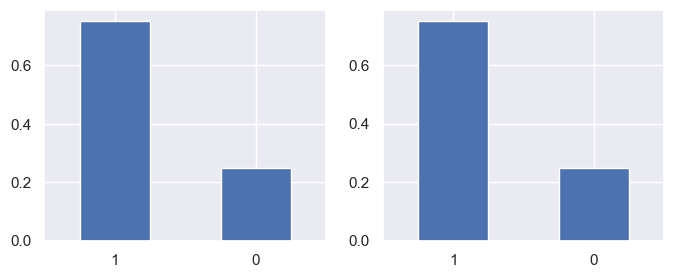

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

plt.figure(figsize=(8,3))

plt.subplot(121)
y_train.value_counts(normalize=True).plot(kind='bar', rot=0);
plt.grid(True);

plt.subplot(122)
y_test.value_counts(normalize=True).plot(kind='bar', rot=0);
plt.grid(True);

In [45]:
def train_model(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    Training model and calculate accuracy 

    PARAMETERS:
    - clf: classifier 
    - X_train: features training 
    - y_train: label training 
    - X_test: features test
    - y_test: label test
    RETURN:
    -  Fitted estimator
    '''

    pipeline = Pipeline([('mms', MinMaxScaler()),('clf', clf)])

    start = time.time()
    print("Training {} :".format(clf.__class__.__name__))
    model = pipeline.fit(X_train, y_train)
    end = time.time()
    training_time = round(end-start,2)
    print("Training time: {} secs".format(training_time))

    start = time.time()
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    end = time.time()
    pred_time = round(end-start,2)
    print("Predicting time: {} secs".format(pred_time))

    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)

    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)

    print("Train Set Score:")
    print("Accuracy Score: {}".format(accuracy_train))
    print("F1 Score: {}".format(f1_train))

    print("Test Set Score:")
    print("Accuracy Score: {}".format(accuracy_test))
    print("F1 Score: {}".format(f1_test))

    return model


In [46]:
clf_rf = RandomForestClassifier(random_state=42)
clf_ab = AdaBoostClassifier(random_state=42)
clf_gnb = GaussianNB()

In [47]:
train_model(clf_rf)

Training RandomForestClassifier :
Training time: 5.12 secs
Predicting time: 1.59 secs
Train Set Score:
Accuracy Score: 0.9999669470657258
F1 Score: 0.9999780364594772
Test Set Score:
Accuracy Score: 0.8652296302009024
F1 Score: 0.912315913595424


Pipeline(steps=[('mms', MinMaxScaler()),
                ('clf', RandomForestClassifier(random_state=42))])

In [48]:
train_model(clf_ab)

Training AdaBoostClassifier :
Training time: 1.48 secs
Predicting time: 0.53 secs
Train Set Score:
Accuracy Score: 0.7866267827926424
F1 Score: 0.8666287898352357
Test Set Score:
Accuracy Score: 0.7867967454594532
F1 Score: 0.866458952249837


Pipeline(steps=[('mms', MinMaxScaler()),
                ('clf', AdaBoostClassifier(random_state=42))])

In [49]:
train_model(clf_gnb)

Training GaussianNB :
Training time: 0.03 secs
Predicting time: 0.03 secs
Train Set Score:
Accuracy Score: 0.7331306086697846
F1 Score: 0.823884829316174
Test Set Score:
Accuracy Score: 0.7312304785408553
F1 Score: 0.8229166666666666


Pipeline(steps=[('mms', MinMaxScaler()), ('clf', GaussianNB())])

### Refinement

In [50]:
def tuning_model(clf, param_grid, X_train=X_train, y_train=y_train, verbose=0):
    '''
    Tuning model using GridSearchCV 

    PARAMETERS:
    - clf: classifier 
    - param_grid: parameter grid will be use for GridSearchCV
    - X_train: features training 
    - y_train: label training 
    - X_test: features test
    - y_test: label test

    RETURN:
    -  Fitted estimator
    '''
    pipeline_rf = Pipeline([('mms', MinMaxScaler()),('clf', clf)])

    grid = GridSearchCV(pipeline_rf, param_grid, scoring='f1', cv=3, verbose=verbose)
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    print("Training time: {} secs".format(round(end-start,2)))

    return grid



In [51]:
params_rf = [{'clf__n_estimators': [10, 50, 100, 150],
            'clf__min_samples_split': [1, 2, 3, 5, 13],
            'clf__min_samples_leaf': [1, 2, 3, 5, 13],
            'clf__max_features':['sqrt', None]}]

grid = tuning_model(clf_rf, params_rf, verbose=0)

Training time: 4089.21 secs


In [52]:
best_est = grid.best_estimator_
print("Best f1_score : {}".format(grid.best_score_))

Best f1_score : 0.9133833978371428


# Results

### Model Evaluation and Validation

In [53]:
start = time.time()
pred_test = best_est.predict(X_test)
pred_train = best_est.predict(X_train)
end = time.time()
print("Predicting time: {} secs".format(round(end-start,2)))

accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

f1_train = f1_score(y_train, pred_train)
f1_test = f1_score(y_test, pred_test)

print("Train Set Score:")
print("Accuracy Score: {}".format(accuracy_train))
print("F1 Score: {}".format(f1_train))

print("Test Set Score:")
print("Accuracy Score: {}".format(accuracy_test))
print("F1 Score: {}".format(f1_test))


Predicting time: 2.15 secs
Train Set Score:
Accuracy Score: 0.9992728354459667
F1 Score: 0.9995169294277809
Test Set Score:
Accuracy Score: 0.876527975937994
F1 Score: 0.9196406163730362


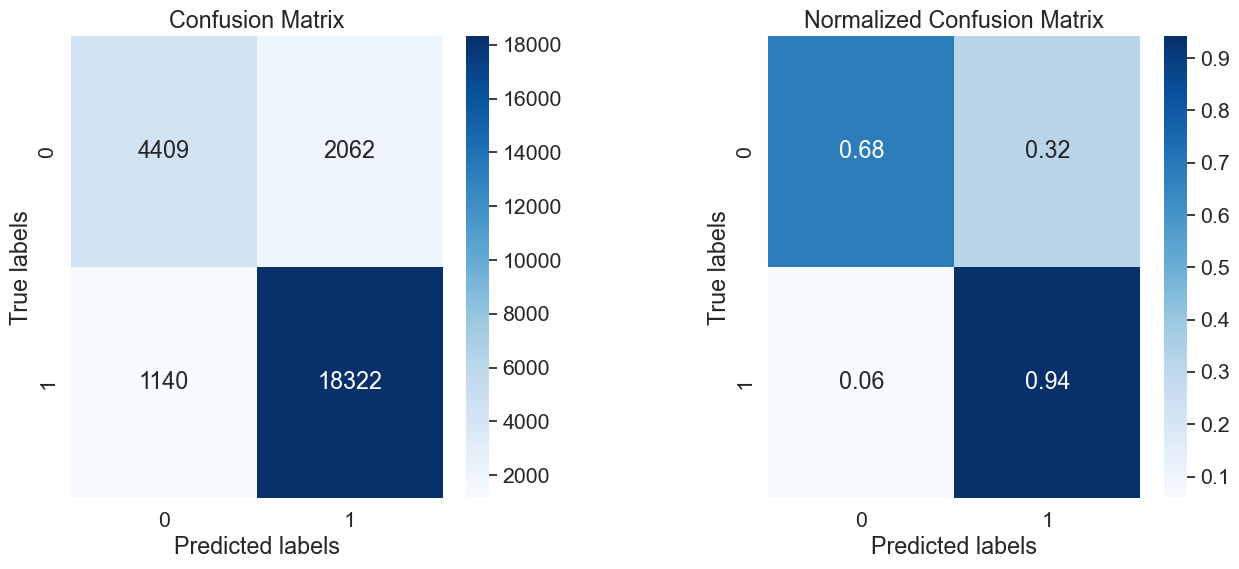

In [84]:
cf_matrix = confusion_matrix(y_test, pred_test)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15,6))


plt.subplot(121)
plt.subplots_adjust(wspace=0.5)
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.grid(True);

plt.subplot(122)
sns.heatmap(cf_matrix_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.grid(True);


In [79]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
best_est[-1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Justification

In [ ]:
init_imp_df = pd.DataFrame(clf_rf.feature_importances_,index=X_train.columns.tolist(),columns=['important_rate']).reset_index()

init_imp_df.rename(columns={'index': 'feature'}, inplace=True)
init_imp_df = init_imp_df.sort_values(by=['important_rate'], ascending=False).reset_index(drop=True)
init_imp_df

,feature,important_rate
0,membership_days,0.417075
1,income,0.257017
2,age,0.244942
3,reward,0.016376
4,Male,0.013329
5,Female,0.011915
6,difficulty,0.010563
7,social,0.007484
8,duration,0.005898
9,mobile,0.004456


In [ ]:
imp_df = pd.DataFrame(best_est[-1].feature_importances_,index=X_train.columns.tolist(),columns=['important_rate']).reset_index()

imp_df.rename(columns={'index': 'feature'}, inplace=True)
imp_df = imp_df.sort_values(by=['important_rate'], ascending=False).reset_index(drop=True)
imp_df

,feature,important_rate
0,membership_days,0.403641
1,income,0.222123
2,age,0.221688
3,reward,0.040309
4,difficulty,0.024988
5,duration,0.020178
6,Male,0.020139
7,social,0.017936
8,web,0.008908
9,Female,0.005962


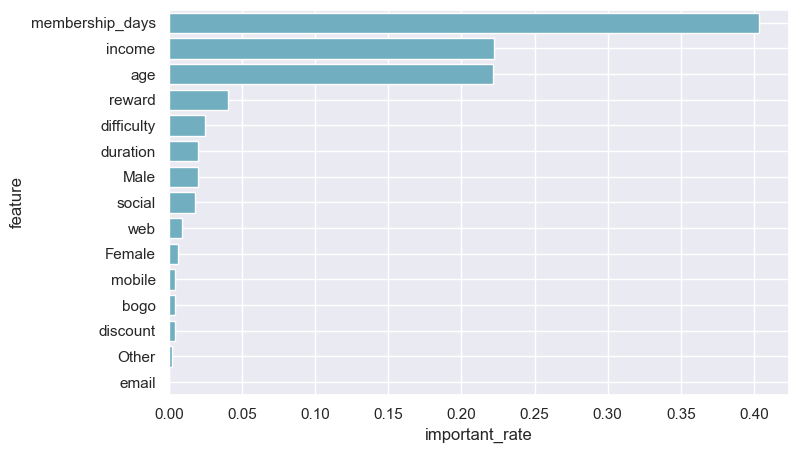

In [ ]:
plt.figure(figsize=(8,5))

sns.barplot(x=imp_df.important_rate, y=imp_df.feature, color='c', data=imp_df)
plt.grid(True);


# Conclusion

### Reflection
To answer the question "Whether will a customer complete a offer from Starbucks or not?" We built a model for predicting the outcome. Beside the exploring data process to get familiar with provided datasets we can separate the process into 4 main steps:
1. Preprocess data with cleaning and combining these datasets
2. Using 3 classifiers `RandomForestClassifier`, `AdaBoostClassifier`, `GaussianNB` to build baseline model and choose the best estimator `RandomForestClassifier`
3. Using `GridSearchCV` to finding the best parameters for `RandomForestClassifier`
4. Prediciting test data and evaluating `accuracy_score`, `f1_score` then plot `confusion_matrix` to summary the result


From the result, we found that 3 most important factors are membership_days, income, age that highly affect to the reponse of users to an offer. 


### Improvement
Because the model still got a lot of incorrect FP so we can imporve by adjust the threshold of positive prediction, apply cost-sensitve learning.